In [ ]:
# Author: Vanshika Gupta
# Jointly with: Prof Chrysafis Vogiatzis 

# Problem: Check if a leader exists in the whole network. Else, then use spectral clustering to obtain a bipartition, and check whether a leader exists in the two induced subgraphs of the bipartition. If there exists a leader, report it; otherwise perform spectral clustering on each of the partitions and continue. We terminate when all leaders have been found or whether an induced subgraph has only 2 nodes

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import operator
from itertools import combinations

#### Read Graph G

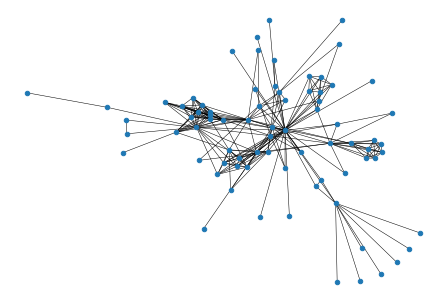

In [2]:
# Read the graph
G1 = nx.les_miserables_graph()
#G1 = nx.karate_club_graph()
G = G1.copy()
nodes = [i for i in G.nodes()]

# Draw initial Graph
pos = nx.spring_layout(G)
plt.figure(1)
fig1 = nx.draw(G,pos,node_size=20,width=0.5) 
plt.draw()

#### Define some functions

In [3]:
def minConductance(G,sortedNodes):
    c=[]
    c1 = []
    current = []
    minConductance = 10
    for i in sortedNodes[:-1]:
        currentNode = i[0]
        current.append(currentNode)
        conductance = nx.conductance(G, current)
        [minConductance, c] = [conductance, current.copy()] if (conductance < minConductance) else [minConductance,c]
    #print("Partition: ", c, "\nMinimum Conductance: ", minConductance)
    for i in G.nodes():
        if i in c:
            pass
        else:
            c1.append(i)
    return [c, c1]

def getEigens(L):
    eigvalues,eigvectors=np.linalg.eig(L.A)
    idx = eigvalues.argsort()
    return np.around(eigvalues[idx],2), np.around(eigvectors[:,idx],3)

def getSortedNodes(G):
    eigen=nx.fiedler_vector(G)
    counter=0
    partition={}
    for i in G.nodes():
        partition[i]=eigen[counter]
        counter+=1
    sortedNodes=sorted(partition.items(), key=operator.itemgetter(1))
    return sortedNodes
    
def getEigenValue(G):
    L=nx.laplacian_matrix(G)
    #eigs,eigvectors=np.linalg.eig(L.A)
    eigs,eigvectors=getEigens(L)
    if(len(eigs)==1):
        return 100
    return eigs[1]

#### Iterative Birpartitioning and Leader Detection

In [4]:
# Peform Iterative Bipartitioning
k = 1
G1 = G.copy()
graphs = [G1.copy()]
partitions = [G1.nodes()]

leaderGraphs = []
leaderPartitions = []
leaders = []

while (len(graphs)!=0 and (not min([len(i)<=2 for i in graphs]))):

    #print([len(i) for i in graphs])
    #print([len(i) for i in leaderGraphs])
    min_idx = 0
    c = 0
    
    eiglist = [getEigenValue(i) for i in graphs]
    eiglist_s = np.argsort(eiglist)
    min_idx = eiglist_s[c]
    
    while (graphs[min_idx].number_of_nodes()<=2):
        c += 1
        min_idx = eiglist_s[c]
        
    G1 = graphs[min_idx]
    nodes = [i for i in G1.nodes()]
    
    b = nx.algorithms.centrality.betweenness_centrality(G1)
    b_s = np.argsort([b[i] for i in G1.nodes()])
    #print("B_i - B_j:", b[nodes[b_s[-1]]] - b[nodes[b_s[-2]]])
    
    if( b[nodes[b_s[-1]]] - b[nodes[b_s[-2]]] >= 0.4):
        leaders.append(nodes[b_s[-1]])
        leaderGraphs.append(G1)
        leaderPartitions.append(list(G1.nodes()))
        del graphs[min_idx]
        del partitions[min_idx]
        
    else:
        
        if(nx.is_connected(G1)):
            
            sortedNodes = getSortedNodes(G1)
            [p1, p2] = minConductance(G1,sortedNodes)
            k = k + 1

            partitions.append(p1)
            partitions.append(p2)
            del partitions[min_idx]

            graphs.append(graphs[min_idx].subgraph(p1))
            graphs.append(graphs[min_idx].subgraph(p2))
            del graphs[min_idx]
            
        else:
            
        
            S = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]

            partitions.append(list(S[0].nodes()))
            partitions.append(list(S[1].nodes()))
            del partitions[min_idx]

            graphs.append(S[0])
            graphs.append(S[1])
            del graphs[min_idx]
        
        
print("The leaders are: ", leaders)

The leaders are:  ['Valjean', 'Myriel', 'Fantine', 'Mabeuf']


['Valjean', 'Myriel', 'Fantine', 'Mabeuf']


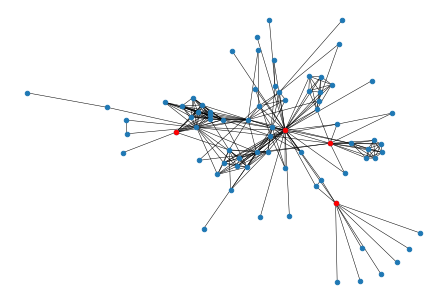

In [5]:
print(leaders)
nx.draw(G,pos,node_size=20,width=0.5)
nx.draw_networkx_nodes(G,pos,nodelist=leaders,node_color='red',node_size=20)